# Modeling
ML Tasks

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
from sklearn.datasets import load_files

corpus = load_files("../data/")

doc_count = len(corpus.data)
print("Doc count:", doc_count)
assert doc_count is 56, "Wrong number of documents loaded, should be 56 (56 stories)"

Doc count: 56


## Vectorizer

In [3]:
from tokenizer import TextWrangler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_stem = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_bow_stem = bow_stem.fit_transform(corpus.data)

tfidf_stem = TfidfVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_tfidf_stem = tfidf_stem.fit_transform(corpus.data)

[nltk_data] Downloading package punkt to ../nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../nltk/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk/...
[nltk_data]   Package wordnet is already up-to-date!


## Models

In [4]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF

n_topics = 5

lda = LatentDirichletAllocation(n_components=n_topics, 
                                learning_decay=0.5, learning_offset=1.,
                                random_state=23)
lsa = TruncatedSVD(n_components=n_topics, random_state=23)
nmf = NMF(n_components=n_topics, solver="mu", beta_loss="kullback-leibler", alpha=0.1, random_state=23)

In [5]:
lda_params = {"lda__learning_decay": [0.5, 0.7, 0.9],
              "lda__learning_offset": [1., 5., 10.]}

## Pipelines

In [6]:
from sklearn.pipeline import Pipeline

lda_pipe = Pipeline([
    ("bow", bow_stem),
    ("lda", lda)
])

lsa_pipe = Pipeline([
    ("tfidf", tfidf_stem),
    ("lsa", lsa)
])

nmf_pipe = Pipeline([
    ("tfidf", tfidf_stem),
    ("nmf", nmf)
])

## Gridsearch

In [7]:
from sklearn.model_selection import GridSearchCV

lda_model = GridSearchCV(lda_pipe, param_grid=lda_params, cv=5, n_jobs=-1)
#lda_model.fit(corpus.data)
#lda_model.best_params_

## Training

In [8]:
lda_pipe.fit(corpus.data)
nmf_pipe.fit(corpus.data)
lsa_pipe.fit(corpus.data)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...', TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
       random_state=23, tol=0.0))])

## Evaluation

In [9]:
print("LDA")
print("Log Likelihood:", lda_pipe.score(corpus.data))

LDA
Log Likelihood: -1281860.968742299


### Visual Inspection

In [10]:
def df_topic_model(vectorizer, model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    
    return df_topic_keywords

In [11]:
print("LDA")
df_topic_model(vectorizer=bow_stem, model=lda_pipe.named_steps.lda, n_words=15)

LDA


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,room,com,fac,hand,hous,know,littl,wom,think,look,way,lady,say,door,mat
Topic 1,hand,know,com,let,room,look,tim,sir,think,littl,say,fac,door,cas,cam
Topic 2,com,room,know,hand,fac,tim,day,cas,way,look,think,door,littl,window,sir
Topic 3,com,hand,room,littl,look,tim,night,hous,op,good,door,know,think,old,cam
Topic 4,com,look,know,cas,turn,left,young,road,littl,think,day,let,hand,fac,shal


In [12]:
print("LSA")
df_topic_model(vectorizer=tfidf_stem, model=lsa_pipe.named_steps.lsa, n_words=15)

LSA


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,com,room,hand,know,look,littl,tim,fac,think,hous,door,let,cas,way,cam
Topic 1,lestrad,bust,oldacr,mccarthy,mcfarlane,norwood,mycroft,sarah,napoleon,jona,pearl,moriarty,beppo,hark,pap
Topic 2,godfrey,colonel,staunton,straker,cunningham,hors,emswor,stabl,moor,armstrong,overton,bicyc,jam,ross,alec
Topic 3,hopkin,trev,blessington,carey,stanley,hut,room,smi,harpoon,captain,tregen,pet,stackhurst,ship,moriarty
Topic 4,robert,godfrey,lestrad,ferguson,staunton,mccarthy,lady,shoscomb,emswor,rond,mason,leonardo,coffin,crypt,hopkin


In [13]:
print("NMF")
df_topic_model(vectorizer=tfidf_stem, model=nmf_pipe.named_steps.nmf, n_words=15)

NMF


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,wast,wait,think,turn,us,valu,thought,watch,act,whisp,thing,adv,ask,way,vent
Topic 1,tap,vast,wednesday,veng,shav,untidy,shal,train,unexpect,unwieldy,incid,track,valet,van,ush
Topic 2,mov,vein,tast,thirteen,wish,sunk,unfold,upward,parl,leav,journey,priv,victor,porch,unsight
Topic 3,scyll,tumbl,upset,arm,stat,suff,passeng,sur,tre,test,account,tawny,reach,hang,bind
Topic 4,read,shook,ut,tackl,til,tru,vehic,tel,triumph,arm,villa,jaw,baronet,unev,moth


In [14]:
import pyLDAvis
from pyLDAvis.sklearn import prepare
pyLDAvis.enable_notebook()

prepare(lda_pipe.named_steps.lda, X_bow_stem, bow_stem, mds="tsne")

/home/datadonk23/anaconda3/envs/holmes-topic-models/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       12.909284 -198.852356       1        1  31.289985
3      -40.401997   84.997383       2        1  22.027967
2      108.056335    6.580519       3        1  21.882224
0     -102.226730  -77.321419       4        1  17.854224
4      178.334534 -145.899750       5        1   6.945599, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
6012  Default  162.000000      road  162.000000  30.0000  30.0000
6637  Default  126.000000       son  126.000000  29.0000  29.0000
2615  Default  157.000000      fath  157.000000  28.0000  28.0000
8245  Default  344.000000     young  344.000000  27.0000  27.0000
7536  Default  461.000000      turn  461.000000  26.0000  26.0000
3259  Default  134.000000       hal  134.000000  25.0000  25.0000
4142  Default  418.000000      left  418.000000  24.0000  24.0000
3883  Default  103.000000       jam  103.000000  23.0000  23.0000
4166  Default  178.000000   lestrad  178.000000  22.0000  22.0000
663   Default   39.000000     bicyc   39.000000  21.0000  21.0000
3129  Default   46.000000      grac   46.000000  20.0000  20.0000
1087  Default  604.000000       cas  604.000000  19.0000  19.0000
1398  Default  920.000000       com  920.000000  18.0000  18.0000
1390  Default  161.000000   colonel  161.000000  17.0000  17.0000
4456  Default   33.000000  mccarthy   33.000000  16.0000  16.0000
6806  Default  270.000000      stat  270.000000  15.0000  15.0000
4261  Default  725.000000      look  725.000000  14.0000  14.0000
2211  Default   40.000000       duk   40.000000  13.0000  13.0000
7413  Default   80.000000     track   80.000000  12.0000  12.0000
4031  Default  782.000000      know  782.000000  11.0000  11.0000
5425  Default  366.000000     point  366.000000  10.0000  10.0000
3452  Default  148.000000      hold  148.000000   9.0000   9.0000
3489  Default  113.000000      hors  113.000000   8.0000   8.0000
819   Default  116.000000       boy  116.000000   7.0000   7.0000
1786  Default  554.000000       day  554.000000   6.0000   6.0000
1078  Default   28.000000   carruth   28.000000   5.0000   5.0000
6334  Default  450.000000      shal  450.000000   4.0000   4.0000
4051  Default  359.000000      lady  359.000000   3.0000   3.0000
7209  Default  459.000000       tel  459.000000   2.0000   2.0000
4666  Default   42.000000      moor   42.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
3347   Topic5    9.773091       hea   17.288505   2.0967  -7.0715
7413   Topic5   25.274625     track   80.809778   1.5048  -6.1213
3259   Topic5   33.055100       hal  134.046533   1.2671  -5.8529
2615   Topic5   34.994154      fath  157.885279   1.1604  -5.7959
4679   Topic5   14.531961  moriarty   36.913126   1.7348  -6.6747
4070   Topic5    9.653313  landlord   18.207530   2.0325  -7.0838
8245   Topic5   45.491058     young  344.023681   0.6439  -5.5336
819    Topic5   25.138282       boy  116.376087   1.1346  -6.1267
8109   Topic5   20.027215      wild   76.603513   1.3255  -6.3540
7536   Topic5   48.612482      turn  461.249687   0.4170  -5.4672
4142   Topic5   45.888100      left  418.244803   0.4572  -5.5249
1087   Topic5   49.954125       cas  604.318901   0.1741  -5.4400
1398   Topic5   58.722085       com  920.443585  -0.0850  -5.2783
4261   Topic5   52.117937      look  725.980982   0.0330  -5.3976
6806   Topic5   34.282725      stat  270.934797   0.5998  -5.8165
4031   Topic5   51.899925      know  782.561682  -0.0462  -5.4018
5425   Topic5   36.224887     point  366.676426   0.3523  -5.7613
1786   Topic5   41.347081       day  554.927750   0.0702  -5.6291
6334   Topic5   37.954384      shal  450.669487   0.1927  -5.7147
7264   Topic5   41.926698     think  658.790900  -0.0874  -5.6152
4226   Topic5   42.988290     littl  714.980093  -0.1

In [15]:
prepare(nmf_pipe.named_steps.nmf, X_tfidf_stem, tfidf_stem, mds="tsne")

/home/datadonk23/anaconda3/envs/holmes-topic-models/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/datadonk23/anaconda3/envs/holmes-topic-models/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/datadonk23/anaconda3/envs/holmes-topic-models/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/datadonk23/anaconda3/envs/holmes-topic-models/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -260.016327  116.992622       1        1  56.221760
3      149.773865  259.892151       2        1  12.954579
2      467.121826  -59.565361       3        1  11.409394
1      123.619209 -326.808167       4        1  10.274197
4     -311.655640 -330.295715       5        1   9.140070, topic_info=     Category      Freq       Term     Total  loglift  logprob
term                                                          
6391  Default  1.000000      shook  1.000000  30.0000  30.0000
5760  Default  1.000000       read  1.000000  29.0000  29.0000
7810  Default  1.000000         ut  1.000000  28.0000  28.0000
7177  Default  1.000000        tap  1.000000  27.0000  27.0000
7156  Default  1.000000      tackl  1.000000  26.0000  26.0000
8143  Default  1.000000       wish  1.000000  25.0000  25.0000
7838  Default  1.000000       vast  1.000000  24.0000  24.0000
7340  Default  1.000000        til  1.000000  23.0000  23.0000
7502  Default  1.000000        tru  1.000000  22.0000  22.0000
4716  Default  1.000000        mov  1.000000  21.0000  21.0000
8032  Default  1.000000  wednesday  1.000000  20.0000  20.0000
331   Default  1.000000        arm  1.000000  19.0000  19.0000
7209  Default  1.000000        tel  1.000000  18.0000  18.0000
6251  Default  0.000000      scyll  0.000000  17.0000  17.0000
7189  Default  1.000000       tast  1.000000  16.0000  16.0000
7524  Default  0.000000      tumbl  0.000000  15.0000  15.0000
7844  Default  1.000000       vein  1.000000  14.0000  14.0000
7267  Default  0.000000   thirteen  0.000000  13.0000  13.0000
7799  Default  1.000000      upset  1.000000  12.0000  12.0000
7043  Default  1.000000       sunk  1.000000  11.0000  11.0000
7850  Default  0.000000       veng  0.000000  10.0000  10.0000
7489  Default  0.000000    triumph  0.000000   9.0000   9.0000
6334  Default  1.000000       shal  1.000000   8.0000   8.0000
7842  Default  0.000000      vehic  0.000000   7.0000   7.0000
7424  Default  1.000000      train  1.000000   6.0000   6.0000
7064  Default  1.000000        sur  1.000000   5.0000   5.0000
7667  Default  1.000000     unfold  1.000000   4.0000   4.0000
6348  Default  0.000000       shav  0.000000   3.0000   3.0000
5181  Default  0.000000    passeng  0.000000   2.0000   2.0000
1555  Default  0.000000       corn  0.000000   1.0000   1.0000
...       ...       ...        ...       ...      ...      ...
4614   Topic5  0.208494       mobl  0.225920   2.3122  -6.2460
7083   Topic5  0.351207        sus  0.400458   2.2613  -5.7246
6391   Topic5  1.232480      shook  1.593132   2.1358  -4.4692
7340   Topic5  0.870154        til  1.109480   2.1495  -4.8173
7489   Topic5  0.609926    triumph  0.775330   2.1526  -5.1726
5760   Topic5  1.295004       read  1.837513   2.0426  -4.4197
7810   Topic5  1.147003         ut  1.708401   1.9941  -4.5410
3531   Topic5  0.141179       humy  0.156332   2.2905  -6.6359
1228   Topic5  0.343738    chimney  0.479791   2.0590  -5.7461
7502   Topic5  0.801218        tru  1.453745   1.7967  -4.8998
7493   Topic5  0.222241       trop  0.280080   2.1612  -6.1822
7887   Topic5  0.184656       vicy  0.222301   2.2070  -6.3674
4699   Topic5  0.381446       moth  0.594319   1.9491  -5.6420
7209   Topic5  0.631428        tel  1.311713   1.6614  -5.1380
7336   Topic5  0.325201       tied  0.528540   1.9068  -5.8015
2581   Topic5  0.295465      faith  0.457587   1.9551  -5.8974
4190   Topic5  0.283494        lid  0.446028   1.9393  -5.9387
7108   Topic5  0.335268      swear  0.650209   1.7301  -5.7710
1225   Topic5  0.294906     childr  0.529479   1.8073  -5.8993
1555   Topic5  0.380713       corn  0.901333   1.5307  -5.6439
331    Topic5  0.535031        arm  1.921978   1.1137  -5.3036
406    Topic5  0.361090     attack  0.874719   1.5077  -5.6968
1306   Topic5  0.365233      clear  0.918910   1.4698  -5.6854
1488   Topic5  0.314967

#### Conclusion:

Topic models derived from different approaches look dissimilar. Top word distribution of NMF appears most 
meaningful, mostly because its topics doesn't share same words (due to NMF algorithm). LSA topic model is 
better interpretable than its LDA counterpart. Nonetheless, topics from both are hard to distinguish and 
doesn't make much sense. Therefore I'll go with the NMF topic model for the assginment to novel collections
step.

### Jaccard Index

In [16]:
df_topic_word_lda = df_topic_model(vectorizer=bow_stem, model=lda_pipe.named_steps.lda, n_words=10)
df_topic_word_lsa = df_topic_model(vectorizer=tfidf_stem, model=lsa_pipe.named_steps.lsa, n_words=10)
df_topic_word_nmf = df_topic_model(vectorizer=tfidf_stem, model=nmf_pipe.named_steps.nmf, n_words=10)

In [17]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    jaccard_index = len(s1.intersection(s2)) / len(s1.union(s2))
    return jaccard_index

In [18]:
sims_lda_lsa, sims_lda_nmf, sims_lsa_nmf = {}, {}, {}
assert df_topic_word_lda.shape[0] == df_topic_word_lsa.shape[0] == df_topic_word_nmf.shape[0], "n_topics mismatch"

for ix, row in df_topic_word_lda.iterrows(): 
    l1 = df_topic_word_lda.loc[ix, :].values.tolist()
    l2 = df_topic_word_lsa.loc[ix, :].values.tolist()
    l3 = df_topic_word_nmf.loc[ix, :].values.tolist()
    sims_lda_lsa[ix] = jaccard_index(l1, l2)
    sims_lda_nmf[ix] = jaccard_index(l1, l3)
    sims_lsa_nmf[ix] = jaccard_index(l2, l3)

df_jaccard_sims = pd.DataFrame([sims_lda_lsa, sims_lda_nmf, sims_lsa_nmf])
df_jaccard_sims.index = ["LDA vs LSA", "LDA vs NMF", "LSA vs NMF"]
df_jaccard_sims["mean_sim"] = df_jaccard_sims.mean(axis=1)
df_jaccard_sims

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,mean_sim
LDA vs LSA,0.818182,0.0,0.0,0.052632,0.0,0.174163
LDA vs NMF,0.052632,0.0,0.0,0.000000,0.0,0.010526
LSA vs NMF,0.052632,0.0,0.0,0.000000,0.0,0.010526


#### Conclusion:

Topics derived from different topic modeling approaches are fundamentally dissimilar.

# Document-topic Assignment

In [19]:
nmf_topic_distr = nmf_pipe.transform(corpus.data)

In [20]:
collections_map = {0: "His Last Bow", 1: "The Adventures of Sherlock Holmes",
                   2: "The Case-Book of Sherlock_Holmes", 3: "The Memoirs of Sherlock Holmes",
                   4: "The Return of Sherlock Holmes"}

# Titles created from dominant words in topics
novel_collections_map = {0: "The Whispering Ways Sherlock Holmes Waits to Act on Waste", 
                         1: "Vengeful Wednesdays: Unexpected Incidences on the Tapering Train by Sherlock Holmes",
                         2: "A Private Journey of Sherlock Holmes: Thirteen Unfolded Veins on the Move",
                         3: "Sherlock Holmes Tumbling into the hanging arms of Scylla",
                         4: "The Shooking Jaw of Sherlock Holmes in the Villa of the Baronet"}

In [21]:
print("Novel Sherlock Holmes Short Stories Collections:")
for _,title in novel_collections_map.items():
    print("*", title)

topics = ["Topic" + str(i) for i in range(n_topics)]
docs = [" ".join(f_name.split("/")[-1].split(".")[0].split("_")) 
        for f_name in corpus.filenames]

df_document_topic = pd.DataFrame(np.round(nmf_topic_distr, 3), columns=topics, index=docs)
df_document_topic["assigned_topic"] = np.argmax(df_document_topic.values, axis=1)
df_document_topic["orig_collection"] = [collections_map.get(item, item) for item in corpus.target]
df_document_topic["novel_collection"] = [novel_collections_map.get(item, item) 
                                         for item in df_document_topic.assigned_topic.values]

df_novel_assignment = df_document_topic.sort_values("assigned_topic").loc[:, ["orig_collection", 
                                                                              "novel_collection"]]
df_novel_assignment

Novel Sherlock Holmes Short Stories Collections:
* The Whispering Ways Sherlock Holmes Waits to Act on Waste
* Vengeful Wednesdays: Unexpected Incidences on the Tapering Train by Sherlock Holmes
* A Private Journey of Sherlock Holmes: Thirteen Unfolded Veins on the Move
* Sherlock Holmes Tumbling into the hanging arms of Scylla
* The Shooking Jaw of Sherlock Holmes in the Villa of the Baronet


,orig_collection,novel_collection
THE ADVENTURE OF CHARLES AUGUSTUS MILVERTON,The Return of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE THREE STUDENTS,The Return of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE NAVAL TREATY,The Memoirs of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE COPPER BEECHES,The Adventures of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE RED CIRCLE,His Last Bow,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE SPECKLED BAND,The Adventures of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE YELLOW FACE,The Memoirs of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE MAN WITH THE TWISTED LIP,The Adventures of Sherlock Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE RETIRED COLOURMAN,The Case-Book of Sherlock_Holmes,The Whispering Ways Sherlock Holmes Waits to A...
THE ADVENTURE OF THE THREE GARRIDEBS,The Case-Book of Sherlock_Holmes,The Whispering Ways Sherlock Holmes Waits to A...


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

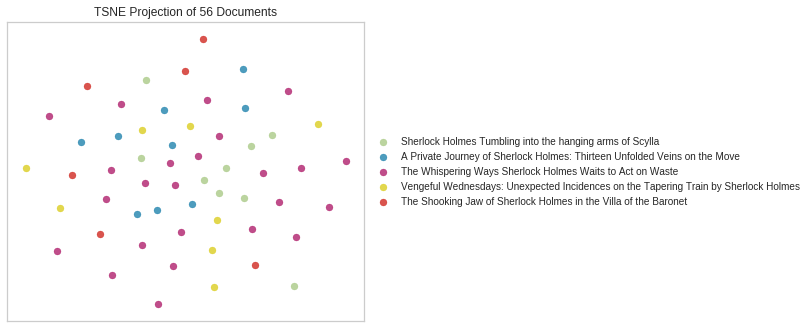

In [22]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(X_tfidf_stem, df_document_topic.novel_collection)
tsne.poof()

#### Conclusion:

A new ordering of short stories from the Sherlock Holmes series into collections based on NMF topic models is possible. Naming of collections according to dominant words in topics is also possible, but they sound strange and doesn't make much sense. The projection of word vectors from the documents looks slightly more structured than the original ordering by the author. Nevertheless the cost of this ordering is that it looses the tension in the canon somehow (eg "The Final Problem" and "The Empty House" are assigned in the same collection). So after all, I'd go with the original ordering by Sir Arthur Conan Doyle.